Desafio Cientista de Dados: Análise Cinematográfica - Indicium


O objetivo desse projeto é treinar um modelo de Machine Learning para ler e interpretar dados de filmes para definir qual o proximo filme a ser lançado.

## **Criação do ambiente de desenvolvimento:**
 Criar um ambiente de desenvolvimento (VENV) e importar as bibliotecas necessarias para a execução do projeto.

In [ ]:
# pip install -r requirements.txt (rodar uma vez para instalar as bibliotecas)

# criar o ambiente virtual (rodar uma vez)
# python -m venv venv

# ativar o ambiente virtual (rodar sempre que for iniciar o projeto)
# Windows: .\venv\Scripts\activate
# Mac/Linux: source venv/bin/activate

##=======================================##

# Importando as bibliotecas necessarias

import pandas as pd # Manipulação de dados
import numpy as np # Calculos Numéricos
import matplotlib.pyplot as plt # # Visualização de dados
import seaborn as sns # Visualização de dados

# Bibliotecas para Machine Learning

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Biblioteca para salvar o modelo

import joblib

## **Análise Exploratória dos dados (EDA)**
 Análise Exploratória dos dados (EDA) -> O objetivo neste passo é descobrir padrões, identificar anomalias, testar hipóteses e verificar suposições com ajuda das estatisticas e representações gráficas.

Nesse passo eu faço uma análise exploratória incial dos dados. Passo fundamental para saber a saúde dos dados, antes de começar a trabalhar nele

In [67]:
display = pd.read_csv('../data/desafio_indicium_imdb.csv')

display.head() # Visualizando as 5 primeiras linhas do dataset
display.info() # Informações gerais do dataset
display.describe() # Estatisticas descritivas
display.isnull().sum() # Verificando valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


Unnamed: 0         0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

Após a verificação dos dados ja noto alguns pontos:

    1- O dataset possui 16 colunas
    2- Coluna unnamed é um indice desnecessario, irei remove-la para evitar poluição
    3- As colunas Released_Year, Runtime e Gross são do tipo object, quando na verdade deveriam ser do tipo numérico.
    4- As colunas Certificate, Meta_score e Gross possuem alguns valores não nulos faltando, isso significa que temos um problema de dados ausentes.
    

In [68]:
display = display.drop('Unnamed: 0', axis=1, errors='ignore') # Removendo a coluna 'Unnamed: 0' se existir
print("\nColunas após a limpeza:", display.columns)

display.head()
display.info()
display.describe()
display.isnull().sum()


Colunas após a limpeza: Index(['Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre',
       'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    object 
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-n

Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

> ### Padronização:

  Agora eu irei padronizar as colunas que deveriam ser do tipo numérico, esse passo é fundamental para a criação do modelo que vem no passo à seguir.

In [69]:
# Primeiro eu vou dar um print nas 5 primeiras linhas da coluna GROSS para entender como ela esta formatada

print(display['Gross'].head())


0    134,966,411
1    534,858,444
2     57,300,000
3      4,360,000
4    377,845,905
Name: Gross, dtype: object


- Após a verificação dos dados ja noto que precisarei apenas remover as virgulas e converter a coluna para float


In [70]:
# Limpando a coluna Gross

display['Gross'] = display['Gross'].str.replace(',', '')

# Convertendo a coluna Gross para numérico, a função pd.to_numeric ja identifica as caracteristicas do número (inteiro ou float)

display['Gross'] = pd.to_numeric(display['Gross'], errors='coerce')

# Verificando se a limpeza foi bem sucedida
print(display['Gross'].head())

0    134966411.0
1    534858444.0
2     57300000.0
3      4360000.0
4    377845905.0
Name: Gross, dtype: float64


- Farei a mesma coisa para Runtime

In [71]:
print(display['Runtime'].head())
display['Runtime'] = display['Runtime'].str.replace('min', '')

display['Runtime'] = pd.to_numeric(display['Runtime'], errors='coerce')
print(display['Runtime'].head())

0    175 min
1    152 min
2    202 min
3     96 min
4    201 min
Name: Runtime, dtype: object
0    175
1    152
2    202
3     96
4    201
Name: Runtime, dtype: int64


 - Ao converter Released_Year para Float, encontrei o seguinte erro: "Algumas linhas possuem o caracter PG, o que torna impossivel de converter para float". A solução que encontrei para esse problema é:
    -> Encontrar as linhas
    -> Identificar o porque "PG" aparece em Released_Year

In [72]:
temp = pd.to_numeric(display['Released_Year'], errors='coerce')

# Encontrar as linhas onde a conversão falhou

linhas_com_erro = display[temp.isnull()]

print("Linhas com erro na conversão de 'Released_Year':")

# Dou um print nas linhas adjacentes a Released_Year para tentar entender o que esta acontecendo
print(linhas_com_erro[['Series_Title', 'Released_Year', 'Certificate']])

# Verifico que os dados estão alterados, ou seja, algum erro de digitação ou formatação ocorreu.
# A linha 965 possui "PG" em Released_Year, o que é incorreto


Linhas com erro na conversão de 'Released_Year':
    Series_Title Released_Year Certificate
965    Apollo 13            PG           U


- Utilizo a função .loc do Pandas para fazer a conversão da linha 965, essa função nos permite acessar os dados de um DataFrame com base nos rótulos (linhas e colunas). E atribúo o ano 1995


In [73]:
display.loc[965, 'Released_Year'] = 1995
display.loc[965, 'Certificate'] = 'U'

In [74]:
print("Linha 965 após a correção:")
print(display.loc[965, ['Released_Year', 'Certificate']])

Linha 965 após a correção:
Released_Year    1995
Certificate         U
Name: 965, dtype: object


- Por fim converto para int64

In [75]:
display['Released_Year'] = pd.to_numeric(display['Released_Year'], errors="coerce")

print(display['Released_Year'].head())

0    1972
1    2008
2    1974
3    1957
4    2003
Name: Released_Year, dtype: int64


> ### Preenchimento de valores nulos:

Agora com os dados padronizados podemos seguir para o proximo passo, que será a criação do modelo que ira preencher os dados nulos no DataFrame.

Como identificamos diversas linhas de dados ausentes (cerca de 427 linhas), eu optei por desenvolver um modelo de machine learning para imputar esses dados, ao inves de simplesmente apaga-los ou simular uma média.

Essa decisão foi tomada devido à grande quantidade de dados ausentes. E essa me parece a escolha mais acertada pelos seguintes motivos:

    - Preservação dos dados
    - Mantém a variabilidade
    - Melhora na qualidade dos dados
    - Redução do viés

> Na célula abaixo será criado o modelo

In [76]:

def preencher_dados_numericos(display, coluna_ausente, colunas_previsoras, modelo=LinearRegression()):
    '''
    Essa função é responsável por preencher valores ausente em uma coluna nmérica usando um modelo de regressão

    Argumentos:
        display: DataFrame do Pandas contendo os dados
        coluna_ausente: Nome da coluna que possui valores ausentes
        colunas_previsoras: lista de colunas que serão usadas como variáveis independentes para prever os valores ausentes

    Retornos:
        DataFrame com os valores preenchidos.
    '''

    # 1. Copiar o dataframe original para evitar modificar os dados originais

    dados_copia = display.copy()

    # 2. Separar os dados em dois conjuntos: um com valores ausentes e outro sem valores ausentes
    # as linhas com os dados completos serão utilizadas para treinar o modelo de regressão
    dados_treino = dados_copia.dropna(subset=[coluna_ausente])

    # linhas com os dados ausentes que serão preenchidas
    dados_prever = dados_copia[dados_copia[coluna_ausente].isnull()]
    
    # 3.Preparar variaveis de entrada e saída

    A_treino = dados_treino[colunas_previsoras]
    B_treino = dados_treino[coluna_ausente]
    A_prever = dados_prever[colunas_previsoras]

    # 4. Treinar o modelo de regressão
    # Esse modelo seria treinado para aprender a relação entre as colunas complestas e as faltantes

    modelo.fit(A_treino, B_treino)

    # 5. Fazer previsões para os valores ausentes
    valores_previstos = modelo.predict(A_prever)

    # Arredondar os valores previstos para o inteiro mais próximo
    valores_previstos = np.round(valores_previstos)

    # 6. Substituir os valores ausentes pelos valores previstos
    # Utilizo o .loc para garantir que os valores sejam atributidos corretamente nos indices

    dados_copia.loc[dados_copia[coluna_ausente].isnull(), coluna_ausente] = valores_previstos

    print(f"Valores ausentes na coluna '{coluna_ausente}' foram preenchidos com sucesso usando {modelo.__class__.__name__}.")

    return dados_copia

''' Criando a previsão para Certificate, como a coluna é categórica um modelo de regressão 
    não vai funcionar justamente por não serem valores numéricos, então optei por preencher
    usando a moda (valor mais frequente), isso vai garantir uma imputação rapida e eficaz, 
'''

def preencher_dados_categoricos(display, coluna_ausente):
    '''
    Essa função é responsável por preencher valores ausente em uma coluna categórica usando a moda (valor mais frequente)

    Argumentos:
        display: DataFrame do Pandas contendo os dados
        coluna_ausente: Nome da coluna que possui valores ausentes

    Retornos:
        DataFrame com os valores preenchidos.
    '''

    # 1. Copiar o dataframe original para evitar modificar os dados originais

    dados_copia = display.copy()

    # 2. Calcular a moda (valor mais frequente) da coluna categórica
    moda = dados_copia[coluna_ausente].mode()[0]

    # 3. Preencher os valores ausentes com a moda
    dados_copia[coluna_ausente] = dados_copia[coluna_ausente].fillna(moda)

    print(f"Valores ausentes na coluna '{coluna_ausente}' foram preenchidos com sucesso usando a moda: {moda}.")

    return dados_copia

- após a criação do modelo devemos imputar as colunas:

#### Gross
    Utilizando a função de preencher dados numericos do modelo

In [77]:
display = preencher_dados_numericos(
    display=display,
    coluna_ausente='Gross',
    colunas_previsoras=['IMDB_Rating', 'Runtime']
)

Valores ausentes na coluna 'Gross' foram preenchidos com sucesso usando LinearRegression.


#### Meta_score
    Utilizando a função de preencher dados numericos do modelo

In [78]:
display = preencher_dados_numericos(
    display=display,
    coluna_ausente='Meta_score',
    colunas_previsoras=['IMDB_Rating', 'Runtime', 'Gross']
)

Valores ausentes na coluna 'Meta_score' foram preenchidos com sucesso usando LinearRegression.


#### Certificate
    Utilizando a função de preencher dados categóricos do modelo

In [79]:
display = preencher_dados_categoricos(
    display=display,
    coluna_ausente='Certificate'
)

Valores ausentes na coluna 'Certificate' foram preenchidos com sucesso usando a moda: U.


    Após o preenchimentos dos dados eu faço a verificação:

In [80]:
print("\nContagem de valores nulos após a imputação:")
print(display.isnull().sum())


Contagem de valores nulos após a imputação:
Series_Title     0
Released_Year    0
Certificate      0
Runtime          0
Genre            0
IMDB_Rating      0
Overview         0
Meta_score       0
Director         0
Star1            0
Star2            0
Star3            0
Star4            0
No_of_Votes      0
Gross            0
dtype: int64


#### Análise dos dados

A partir dos dados padronizados eu irei criar um grafico de dispersão para entender as relações entre as variaveis com a nota do IMDB.
Optei por um grafico de dispersão por que com ele sera possivel plotar todas as variaveis numéricas do DataFrame em um peso de valor iguas no gráfico contra o IMDB

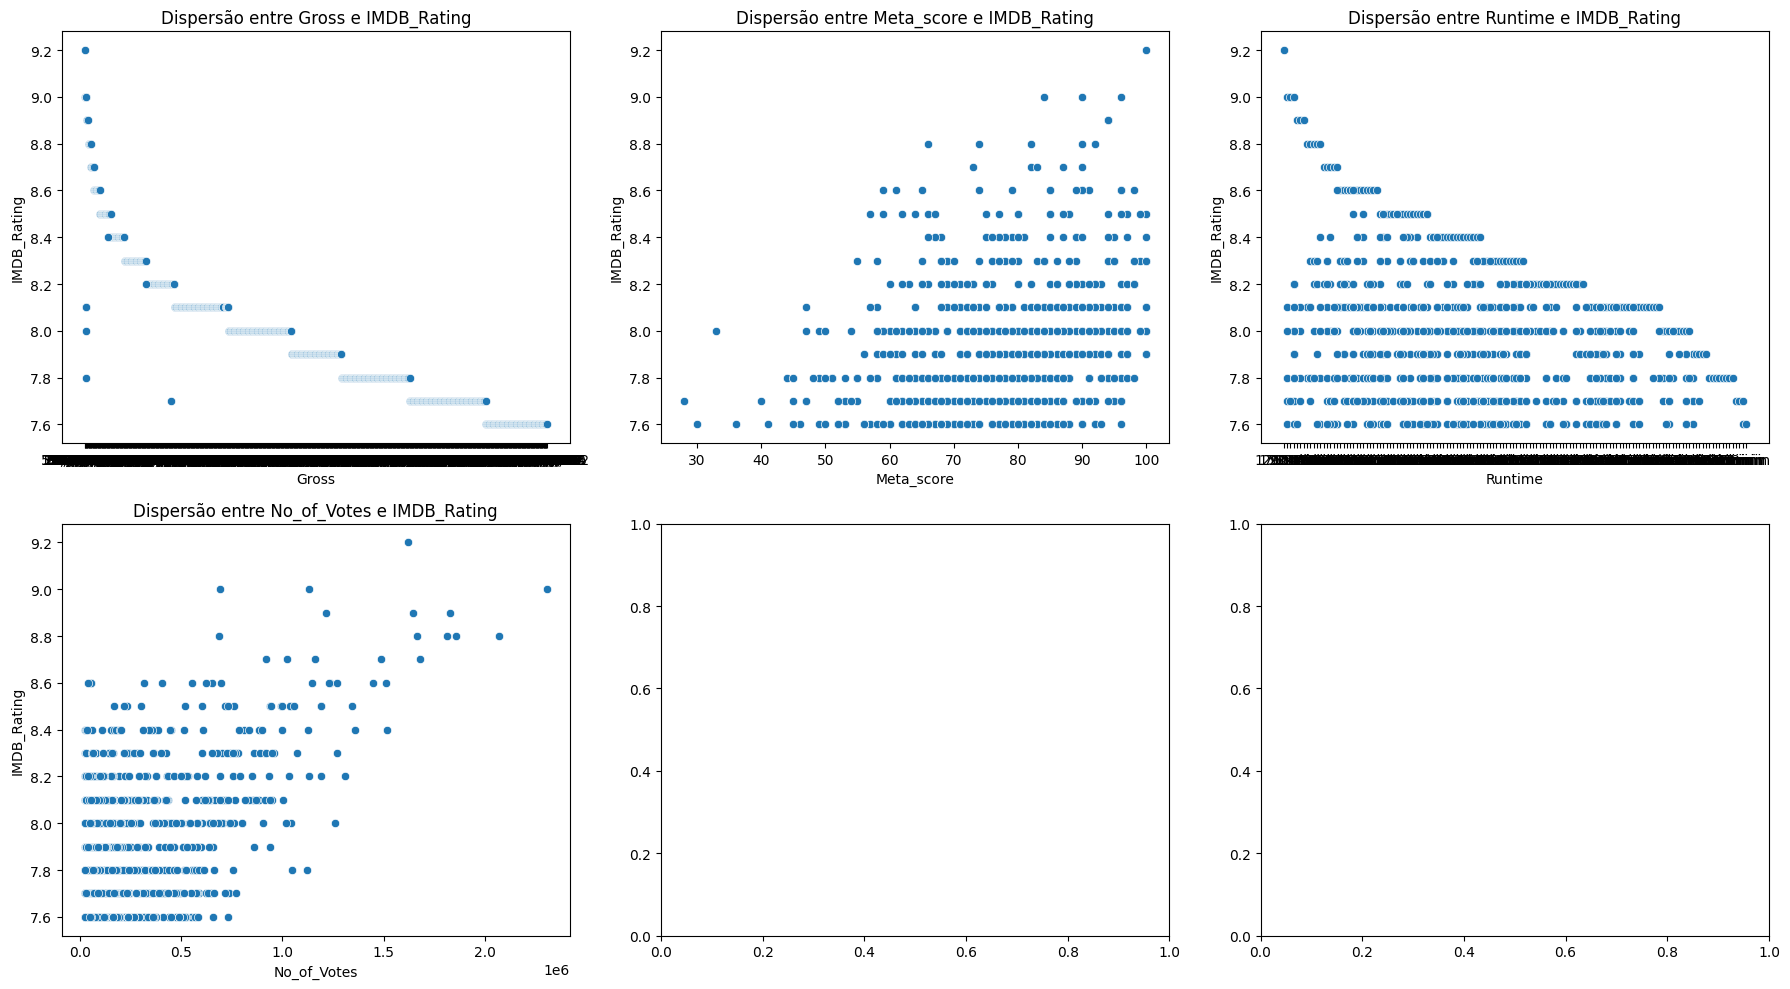

In [81]:
def plotar_Grafico_dispersao(caminho_do_arquivo):

    # Verificando se o arquivo existe e carregando os dados
    try:
        display = pd.read_csv('../data/desafio_indicium_imdb.csv')
    except FileNotFoundError:
        print(f"Erro: O arquivo '{caminho_do_arquivo}' não foi encontrado.")
        return

    # Lista de variaveis para plotar contra IMDB_Rating
    variaveis = ['Gross', 'Meta_score', 'Runtime', 'No_of_Votes']

    # Configuração da figura de plotagem
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10)) # 2 linhas, 3 colunas
    axes = axes.flatten()  # Achatar a matriz de eixos para facilitar a iteração

    # Plotar cada variavel contra IMDB_Rating
    for i, var in enumerate(variaveis):
        if var in display.columns and 'IMDB_Rating' in display.columns:
            sns.scatterplot(data=display, x=var, y='IMDB_Rating', ax=axes[i])
            axes[i].set_title(f'Dispersão entre {var} e IMDB_Rating')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('IMDB_Rating')
        else:
            print(f"Coluna {var} ou IMDB_Rating não encontrada no DataFrame.")
            axes[i].set_visible(False)  # Ocultar o eixo se a coluna não existir
        
    plt.tight_layout()  # Ajustar o layout para evitar sobreposição
    plt.show()

plotar_Grafico_dispersao('../data/desafio_indicium_imdb.csv')

>Dado os graficos acima podemos afirmar que:

**Gross vs IMDb_Rating**: Não existe uma forte correlação entre ganhos de bilheteria de um filme (Gross) e sua classificação no IMDb devido aos pontos estarem muito espalhados horizontalmente

**Meta-score vs IMDb_Rating**: Existe uma correlação positiva embora imperfeita, é possível observar em a medida que o Meta-score aumenta, o IMBd_Rating também tende a aumentar

**Runtime vs IMDb_Rating**: O grafico de dispersão entre Runtime e IMDb_rating mostra uma linha horizontal de pontos que estão fortemente concentrados, isso mostra que muitos filmes possuem Runtime semelhantes mas uma ampla gama de IMDb_Rating mostrando que a duração de um filme não é uma forma confiável de prever a sua classificação.

**No_of_Votes vs IMDb_Rating**: Esse gráfico mostra uma relação positiva, embora seja claro que filmes com bastante números de votos tendem a possuir uma nota mais alta no IMDb.

>  levantar hipóteses

## **Respostas da questão 2 do processo seletivo**

----

>##### Alternativa A) Qual filme você recomendaria para uma pessoa que você não conhece? 

Após analisar os graficos da EDA, notei que o numero de votos é fortemente relacionado à nota do IMDb, então eu claramente recomendaria o filme com o maior número de votos, pois sugere que é um filme popular e amplamente aclamado pela crítica. Segue o codigo na proxima célula para encontrar esse filme no DataFrame


In [82]:
def encontrar_maior_numero_votos(display):
    try:
        display = pd.read_csv('../data/desafio_indicium_imdb.csv')
        
        # o metodo idxmax() retorna o indice do maior valor na coluna 'No_of_Votes'
        filme_mais_votado = display.loc[display['No_of_Votes'].idxmax()]
        print("Filme com o maior número de votos:")
        print(filme_mais_votado[['Series_Title', 'No_of_Votes', 'IMDB_Rating']])
    except FileNotFoundError:
        print("Erro: O arquivo 'desafio_indicium_imdb.csv' não foi encontrado.")

encontrar_maior_numero_votos(display)

Filme com o maior número de votos:
Series_Title    The Dark Knight
No_of_Votes             2303232
IMDB_Rating                 9.0
Name: 1, dtype: object




> *Após a analise dos dados o filme recomendado seria: The Dark Knight, 9.0 (IMDb)*


Porém eu gostaria de utilizar mais duas métricas para validar a recomendação, elas são.
-   O filme com a maior classificação (IMDb)

In [84]:
def encontrar_maior_IMDb_Rating(display):
    try:
        display = pd.read_csv('../data/desafio_indicium_imdb.csv')

        maior_imdb = display.loc[display['IMDB_Rating'].idxmax()]
        print("Filme com a maior classificação (IMDb):")
        print(maior_imdb[['Series_Title', 'IMDB_Rating', 'No_of_Votes']])
    except FileNotFoundError:
        print("Erro: O arquivo 'desafio_indicium_imdb.csv' não foi encontrado.")

encontrar_maior_IMDb_Rating(display)

Filme com a maior classificação (IMDb):
Series_Title    The Godfather
IMDB_Rating               9.2
No_of_Votes           1620367
Name: 0, dtype: object



> *O filme com o maior nota no IMDB é: The Godfather, 9.2 (IMDB)*

- E uma a junção das duas métricas, o filme com o maior numero de votos e maior nota do IMDB em paralelo, codigo na proxima célula:

In [86]:
def maior_votos_e_nota(display):
    try:
        display = pd.read_csv('../data/desafio_indicium_imdb.csv')

        # Encontrar o maior número de votos
        max_votos = display['No_of_Votes'].max()

        # Filtrar os filmes que têm o maior número de votos
        filmes_com_mais_votos = display[display['No_of_Votes'] == max_votos]

        # Dentre esses filmes, encontrar aquele com a maior nota do IMDb
        filme_recomendado = filmes_com_mais_votos.loc[filmes_com_mais_votos['IMDB_Rating'].idxmax()]

        print("Filme com o maior número de votos e maior nota do IMDb:")
        print(filme_recomendado[['Series_Title', 'No_of_Votes', 'IMDB_Rating']])
    except FileNotFoundError:
        print("Erro: O arquivo 'desafio_indicium_imdb.csv' não foi encontrado.")

maior_votos_e_nota(display)

Filme com o maior número de votos e maior nota do IMDb:
Series_Title    The Dark Knight
No_of_Votes             2303232
IMDB_Rating                 9.0
Name: 1, dtype: object


Por fim o filme mais recomendado seria justamente:
>### **a. The Dark Knight, 9,0 (IMDB)**

----

>##### Alternativa b) Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme